In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent.


We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models. For metrics are better the smaller they are.

> Since our data has multiple features we are going to use multivariate or dependent multi-series forecasting methods

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# clean_METData = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_METData.csv')
data = clean_METData[['date','T2M_RANGE','T2M_MIN','WS10M_MAX','PRECTOTCORR','SPI']]
data.head()

,date,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
0,1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1,1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
2,1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
3,1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
4,1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
date,,,,,
1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01 '
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1991-01-29 00:00:00 --- 2019-12-31 00:00:00   (n=1510)
Test dates  : 2020-01-07 00:00:00 --- 2023-03-28 00:00:00   (n=169)


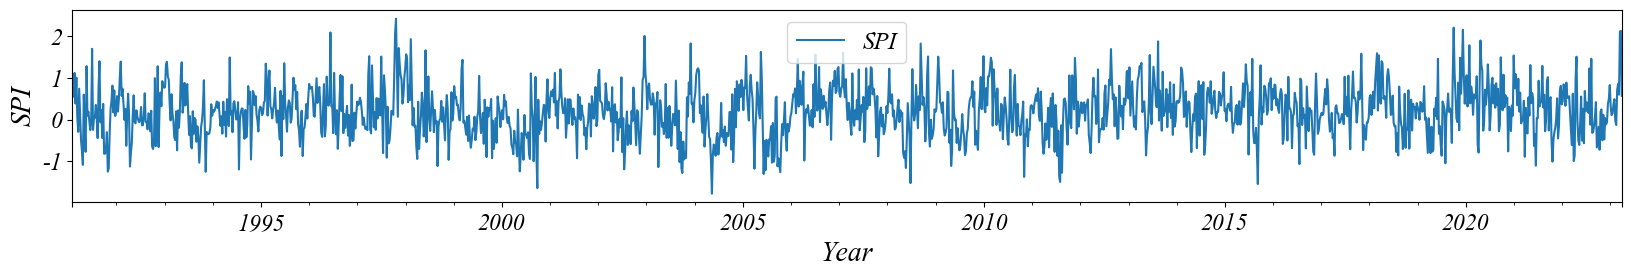

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
rdata['SPI'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2 )
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17)

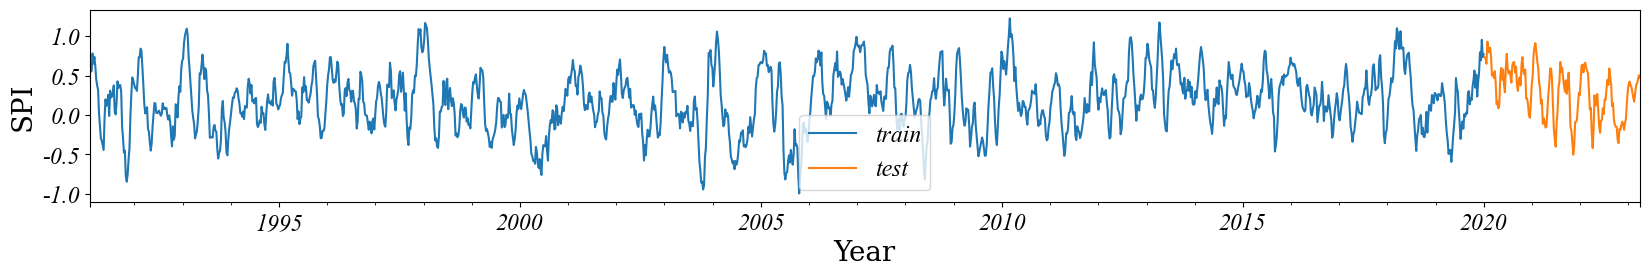

In [ ]:
# Plot
# ==============================================================================
#define font family to use for all text
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['font.family'] = 'Times New Roman'

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.rcParams['axes.unicode_minus'] = False
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

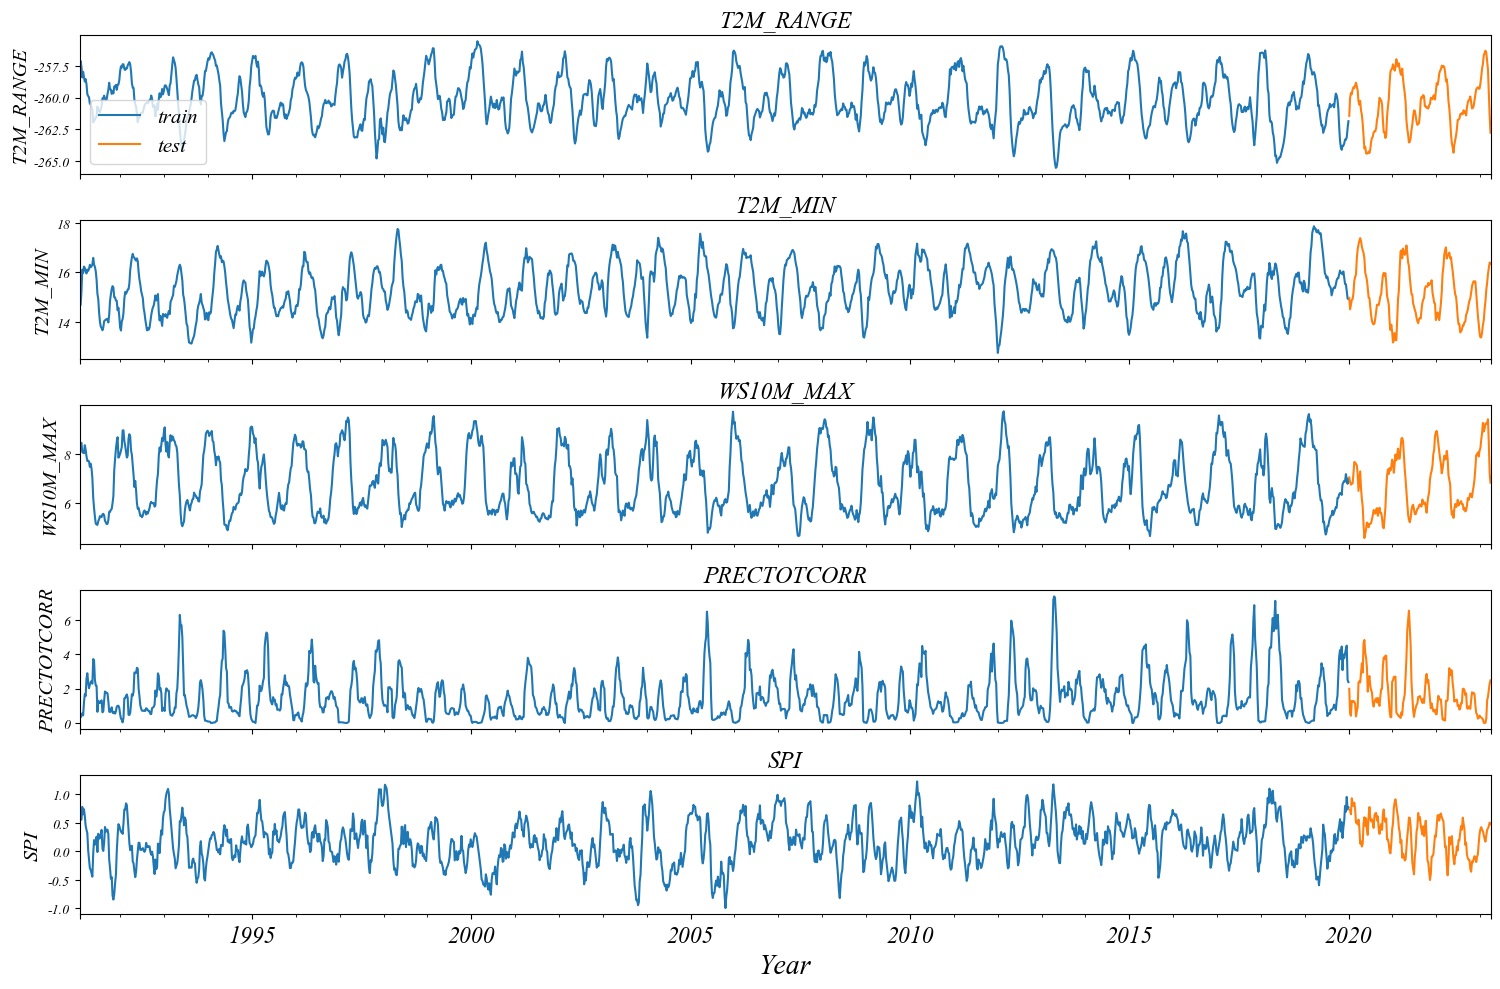

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10), sharex=True)
font2 = {'family':'serif','color':'black','size':20}

data_train['T2M_RANGE'].plot(label='train', ax=axes[0])
data_test['T2M_RANGE'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('Year',fontdict = font2)
axes[0].set_ylabel('T2M_RANGE',fontsize=15)
axes[0].set_title('T2M_RANGE',fontsize=17)
axes[0].legend(fontsize=15)

data_train['T2M_MIN'].plot(label='train', ax=axes[1])
data_test['T2M_MIN'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('Year',fontdict = font2)
axes[1].set_ylabel('T2M_MIN',fontsize=15)
axes[1].set_title('T2M_MIN',fontsize=17)

data_train['WS10M_MAX'].plot(label='train', ax=axes[2])
data_test['WS10M_MAX'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('Year',fontdict = font2)
axes[2].set_ylabel('WS10M_MAX',fontsize=15)
axes[2].set_title('WS10M_MAX',fontsize=17)

data_train['PRECTOTCORR'].plot(label='train', ax=axes[3])
data_test['PRECTOTCORR'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('Year',fontdict = font2)
axes[3].set_ylabel('PRECTOTCORR', fontsize=15)
axes[3].set_title('PRECTOTCORR',fontsize=17)

data_train['SPI'].plot(label='train', ax=axes[4])
data_test['SPI'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('Year',fontdict = font2)
axes[4].set_ylabel('SPI',fontsize=15)
axes[4].set_title('SPI',fontsize=17)
plt.xticks(fontsize=17)
fig.tight_layout()
plt.show();

### Dependent multi-series forecasting (Multivariate forecasting)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

#### LGBMRegressor

> Multiseries Single-Step

In [ ]:
from lightgbm import LGBMRegressor
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(),
                 lags               = 4,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [10, 50, 100, 200]
param_grid = {
    'n_estimators': [50, 100,200],
    'max_depth': [5, 10, 15]
}
levels = ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

36 models compared for 5 level(s). Number of iterations: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,max_depth,n_estimators
11,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.224771,5,200
14,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 200}",0.225393,10,200
13,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.225821,10,100
20,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.225974,5,200
10,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.226248,5,100
17,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 200}",0.226415,15,200
19,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.226584,5,100
29,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.227510,5,200
28,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.227514,5,100
16,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 100}",0.227722,15,100


In [ ]:
print(results.lags[11])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(max_depth= 5, n_estimators=200),
                 lags               = 50,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12760
[LightGBM] [Info] Number of data points in the train set: 7300, number of used features: 55
[LightGBM] [Info] Start training from score 0.002071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [ ]:
# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = levels,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12760
[LightGBM] [Info] Number of data points in the train set: 7300, number of used features: 55
[LightGBM] [Info] Start training from score 0.002071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

  0%|          | 0/169 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,T2M_RANGE,0.326912,0.169308,0.001255
1,T2M_MIN,0.166250,0.044509,0.011029
2,WS10M_MAX,0.199721,0.064063,0.029530
3,PRECTOTCORR,0.326004,0.219623,0.453441
4,SPI,0.104968,0.017501,1.221493



Backtest predictions


,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2020-01-07,-261.231748,14.849500,7.264263,1.751451,0.630471
2020-01-14,-260.910365,14.905801,7.240189,1.514855,0.750960
2020-01-21,-259.390006,14.576666,7.066566,0.149684,0.586404
2020-01-28,-259.030136,14.769960,6.963044,0.428177,0.612644


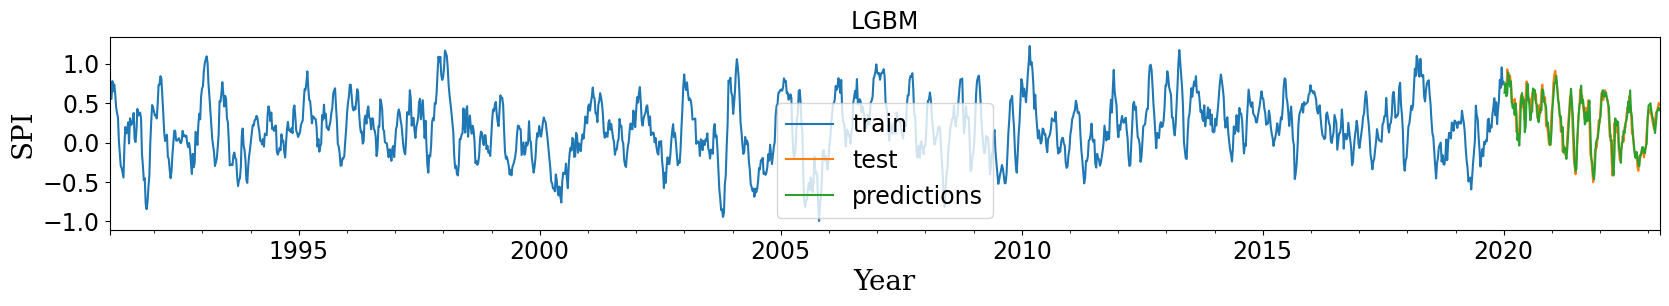

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='LGBM')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

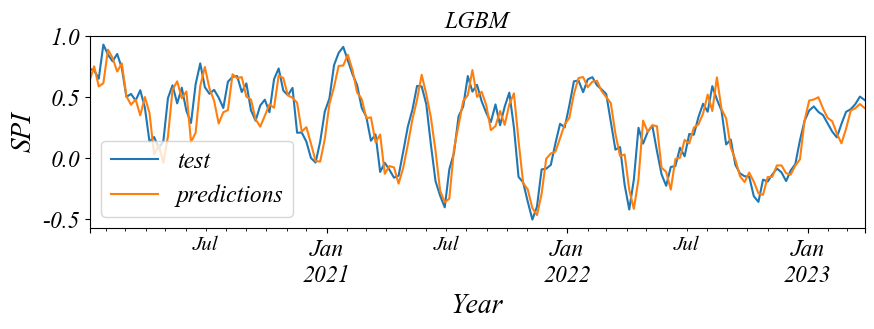

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2.5))
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='LGBM')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
# SPI
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['SPI'],backtest_predictions['SPI'])
mse = mean_squared_error(data_test['SPI'],backtest_predictions['SPI'])
r2 = r2_score(data_test['SPI'],backtest_predictions['SPI'])
rmse = math.sqrt(mean_squared_error(data_test['SPI'],backtest_predictions['SPI']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.10496827931068135
MSE is 0.01750105781207696
RMSE is 0.13229156364665495
R2 is 0.8306948599312807


In [ ]:
#T2M_RANGE
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
mse = mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
r2 = r2_score(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.32691235256311973
MSE is 0.16930828243497162
RMSE is 0.4114708767761962
R2 is 0.9583147845717096


In [ ]:
#T2M_MIN
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
mse = mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
r2 = r2_score(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.16624985041470253
MSE is 0.04450886658815823
RMSE is 0.2109712458799972
R2 is 0.9605842653297929


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
mse = mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
r2 = r2_score(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
rmse = math.sqrt(mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.1997206445297311
MSE is 0.06406325293369496
RMSE is 0.25310719652687663
R2 is 0.9530876563649809


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
mse = mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
r2 = r2_score(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
rmse = math.sqrt(mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.32600416285947664
MSE is 0.2196225280006212
RMSE is 0.4686390167288904
R2 is 0.8513237149035799


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.22477105793554228
MSE is 0.1030007975539046
RMSE is 0.32093737325824895
R2 is 0.910801056220269


In [ ]:
forecaster.fit(data)
forecaster

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12760
[LightGBM] [Info] Number of data points in the train set: 8145, number of used features: 55
[LightGBM] [Info] Start training from score 0.001910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(max_depth=5, n_estimators=200) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Window size: 50 
Series levels (names): ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-01-29 00:00:00'), Timestamp('2023-03-28 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 7D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_le

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=300)
predictions.head()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2023-04-04,-263.175286,16.393734,6.317472,2.341914,0.413676
2023-04-11,-263.159329,16.427893,5.956084,2.576044,0.376113
2023-04-18,-263.148913,16.336313,5.721835,2.815911,0.277889
2023-04-25,-262.732077,16.364496,5.818511,2.882524,0.180485
2023-05-02,-262.422372,16.336048,5.747698,2.912341,0.103003


In [ ]:
predictions.tail(3)

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2028-12-12,-258.700558,14.868273,6.853458,1.691398,0.647213
2028-12-19,-258.620459,14.858381,7.059843,1.668296,0.666012
2028-12-26,-258.086325,14.871384,7.164011,1.724057,0.700038


Text(0, 0.5, 'SPI')

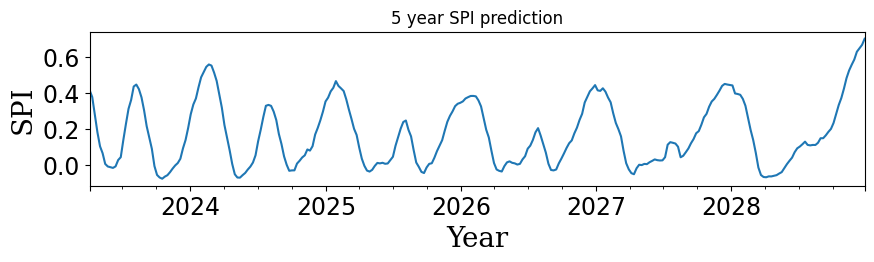

In [ ]:
# Plot predictions
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
predictions['SPI'].plot(ax=ax,title='5 year SPI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)

> Multivarite Multistep

In [ ]:
from lightgbm import LGBMRegressor
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(),
                 level              = 'SPI',
                 lags               = 200,
                 steps              = 169,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Window size: 200 
Target serie

In [ ]:
# Backtesting MultiVariate
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           steps                 = 169,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = False,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/1 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,SPI,0.283246,0.112996,1.356026



Backtest predictions


,SPI
2020-01-07,0.730403
2020-01-14,0.809013
2020-01-21,0.703604
2020-01-28,0.513663


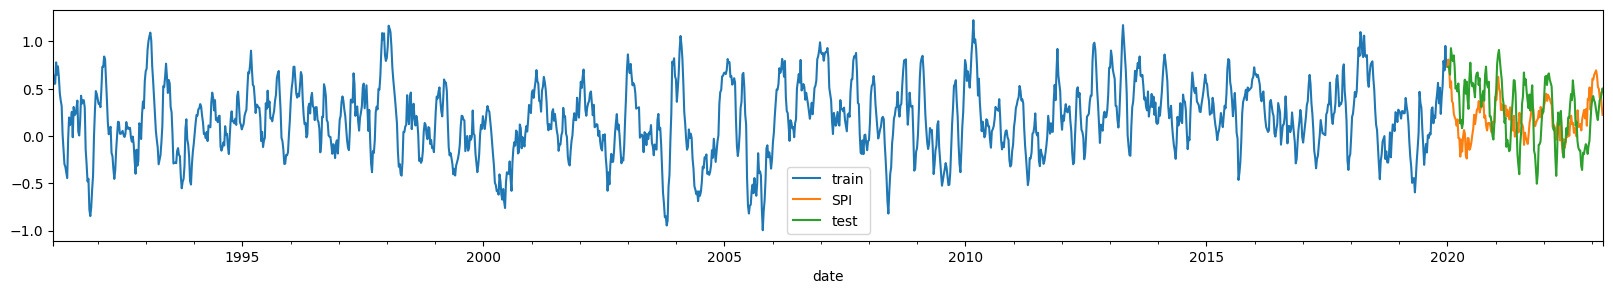

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
data_train['SPI'].plot(ax=ax, label='train')
backtest_predictions.plot(ax=ax, label='predicted')
data_test['SPI'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['SPI'],backtest_predictions)
mse = mean_squared_error(data_test['SPI'],backtest_predictions)
r2 = r2_score(data_test['SPI'],backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test['SPI'],backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.28324581051906855
MSE is 0.11299588487908364
RMSE is 0.3361486053504962
R2 is -0.09312158853852592


In [ ]:
forecaster.fit(data)
forecaster

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Window size: 200 
Target serie

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
predictions.head(3)

,SPI
2023-04-04,0.351659
2023-04-11,0.218171
2023-04-18,0.187782


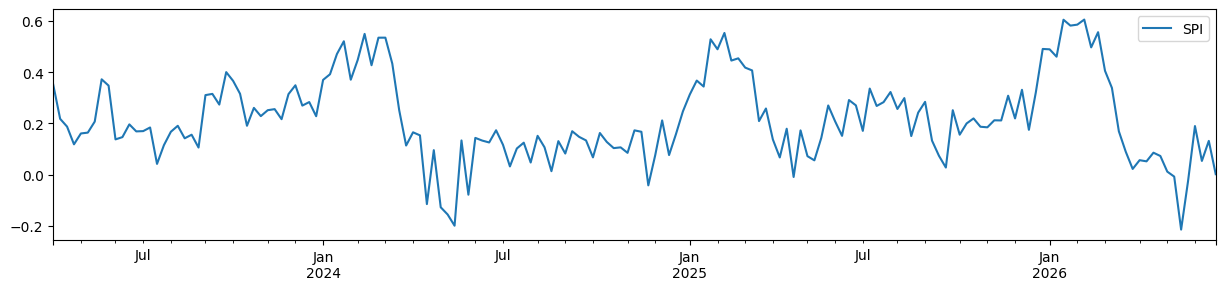

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
predictions.plot(ax=ax, label='predictions')
ax.legend();